# ECE590 Smart Cameras Homework 3
## Nathan Inkawhich

**Note:** This notebook contains the DNN training code for the deep learning based demosaicing model. After running this notebook, a DNN is saved then we will use that DNN in the other notebook to use it with the cameras.

**Question 3.**

Develop and train a neural network similar to the one described in the Deep mosaicking paper. You will not have time or resources to train as long as in the paper, let's see how well we can do with more modest training. You can use the Kodak images on line at http://r0k.us/graphics/kodak/ as a ground truth training data set. If you break the kodak images in to 64 by 64 groups you will have just over 1000 training images. Do not include the denosing aspect of the problem in your training, feel free to augement training with additonal images. Let's also focus on building a network to work initially on 64 by 64 patches. 

Train your network for 10-12 hours, analyze how the loss function behaves during training, test your network on some actual RGB images obtained from the tegra camera. Compare your trained network with your linear demosaicking algorithm.

The dataset used in the deep demosaicking paper is also on line and may be used if you want to improve our system performance or design. see https://groups.csail.mit.edu/graphics/demosaicnet/dataset.html 

**Main paper reference**

[1] - Michaël Gharbi, Gaurav Chaurasia, Sylvain Paris, and Frédo Durand. 2016. Deep joint demosaicking and denoising. ACM Trans. Graph. 35, 6, Article 191 (November 2016), 12 pages. DOI: https://doi.org/10.1145/2980179.2982399

### Imports and setup path to image directory

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

#import tensorflow as tf
import multiprocessing as mp
import keras
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras.optimizers as optimizers
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

print(K.tensorflow_backend._get_available_gpus())

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Set path to dataset root directory
DATA_ROOT = "drive/My Drive/Kodak_Images"

# List files in data root directory
img_list = os.listdir(DATA_ROOT)
print("List of Kodak Images:\n",img_list)


List of Kodak Images:
 ['IMG0018.tif', 'IMG0024.tif', 'IMG0019.tif', 'IMG0022.tif', 'IMG0023.tif', 'IMG0021.tif', 'IMG0009.tif', 'IMG0008.tif', 'IMG0020.tif', 'IMG0011.tif', 'IMG0005.tif', 'IMG0004.tif', 'IMG0010.tif', 'IMG0006.tif', 'IMG0012.tif', 'IMG0013.tif', 'IMG0007.tif', 'IMG0003.tif', 'IMG0017.tif', 'IMG0016.tif', 'IMG0002.tif', 'IMG0014.tif', 'IMG0001.tif', 'IMG0015.tif']


Now that we have hooked into the dataset, we can print a few sample images.

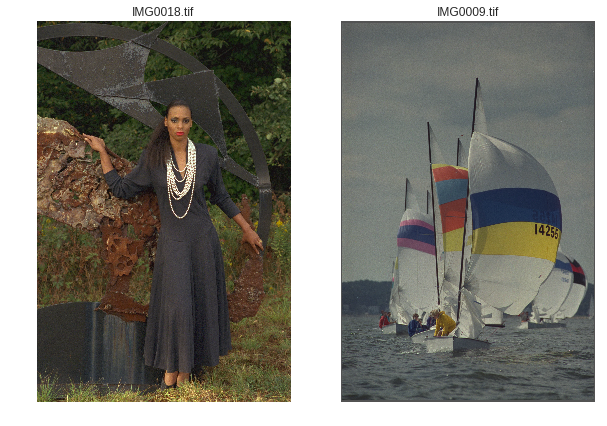

In [3]:
# Plot some sample images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(plt.imread(DATA_ROOT+"/"+img_list[0]))
plt.title(img_list[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(plt.imread(DATA_ROOT+"/"+img_list[6]))
plt.title(img_list[6])
plt.axis("off")
plt.show()

**Create mosaiced representation**

In [1], the authors do not have Bayer images captured directly from a camera so they create their own approximate Bayer images by subsampling RGB images. From [1], "we create the training set from millions of sRGB images, generating the corresponding mosaicked arrays by leaving out two color channels per pixel and adding noise." Here we will write the function to do this downsampling.

First, lets get the indexing scheme down:

In [4]:
s = np.random.randint(low=0,high=100,size=(3,4,4))
b = np.zeros((4,4))
# Red
b[0::2,0::2] = s[0,0::2,0::2]
# Green-1
b[0::2,1::2] = s[1,0::2,1::2]
# Blue
b[1::2,1::2] = s[2,1::2,1::2]
# Green-2
b[1::2,0::2] = s[1,1::2,0::2]

print("Sample Image:\n",s)
print("Sample Bayer:\n",b)

Sample Image:
 [[[40 32 49 74]
  [ 6 98 29 28]
  [93 55 15 21]
  [18 47 52 49]]

 [[41  2 41 88]
  [ 6 86 56 85]
  [79 74 96 27]
  [ 9 65 91 49]]

 [[51 65 50 49]
  [87 16 73  8]
  [13 18 22 92]
  [ 7 65  0 54]]]
Sample Bayer:
 [[40.  2. 49. 88.]
 [ 6. 16. 56.  8.]
 [93. 74. 15. 27.]
 [ 9. 65. 91. 54.]]


Now we write helper functions to help with the transition from full scale RGB to bayer and from bayer to small RGBG. 

- ```create_approximate_bayer_from_rgb``` - take a formed RGB image and approximate it's Bayer representation by subsampling in the color dimension. Return the approximate 1-channel bayer image.

- ```bayer_to_downsampled_rgbg``` - we will define the DNN input to be a 4x32x32 RGBG input which is formed from a reshaped bayer image. This function returns a reshaped bayer at this dimensionality.

In [0]:
def create_approximate_bayer_from_rgb(rgb_image):
    """ 
    Here, we will assume the Bayer image is of the form:
    
    R  G1 R  G1
    G2 B  G2 B
    R  G1 R  G1
    G2 B  G2 B
    
    This function will subsample the rgb image to get the Bayer form.
    """
    bayer = np.zeros_like(rgb_image[:,:,0])
    #print("Input Image Shape: ", rgb_image.shape)
    #print("Bayer Image Shape: ",bayer.shape)
    
    # Red
    bayer[0::2,0::2] = rgb_image[0::2,0::2,0]
    # Green-1
    bayer[0::2,1::2] = rgb_image[0::2,1::2,1]
    # Blue
    bayer[1::2,1::2] = rgb_image[1::2,1::2,2]
    # Green-2
    bayer[1::2,0::2] = rgb_image[1::2,0::2,1]

    return bayer

def plot_rgb_and_bayer(rgb,bay):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(rgb)
    plt.title("RGB")
    #plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(bay,cmap="viridis")
    plt.title("Bayer")
    #plt.axis("off")
    #plt.grid("off")
    plt.show()
    
def bayer_to_downsampled_rgbg(bayer_img):
    # Red
    red = np.copy(bayer_img[0::2,0::2])
    # Green-1
    green1 = np.copy(bayer_img[0::2,1::2])
    # Blue
    blue = np.copy(bayer_img[1::2,1::2])
    # Green-2
    green2 = np.copy(bayer_img[1::2,0::2])
    
    return np.array([red,green1,blue,green2])


Show an example of a RGB image and the created Bayer image. 

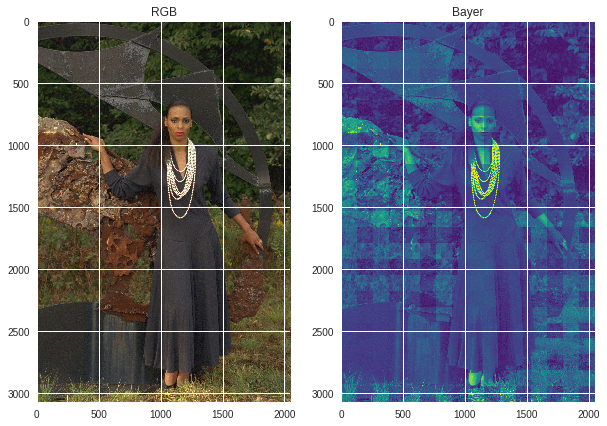

Downsampled RGB shape:  (4, 1536, 1024)


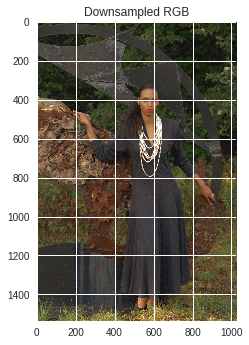

In [6]:
sample_rgb_img = plt.imread(DATA_ROOT+"/"+img_list[0])
bayer = create_approximate_bayer_from_rgb(np.copy(sample_rgb_img))
plot_rgb_and_bayer(np.copy(sample_rgb_img), np.copy(bayer))
down_rgb = bayer_to_downsampled_rgbg(bayer)

print("Downsampled RGB shape: ",down_rgb.shape)
plt.imshow(np.copy(down_rgb[0:3,:,:]).transpose(1,2,0))
plt.title("Downsampled RGB")
plt.show()


## Create dataset for training DNN


Now that we have some of the basic functionality for handling RGB and Bayer images, we can create our training dataset for use with the DNN. The process is as follows for a given Kodak image:

- Split RGB image into 64x64 patches (size=3x64x64)
- Create approximate Bayer image from each patch using subsampling in the color dimension (size=1x64x64)
- Create RGBG from Bayer image (size=4x32x32)
- Save each (RGBG, patch) as (input,ground-truth) pairs in the training dataset




Image:  drive/My Drive/Kodak_Images/IMG0018.tif
	Full frame shape:  (3072, 2048, 3)
	Tiles shape:  (1536, 64, 64, 3)


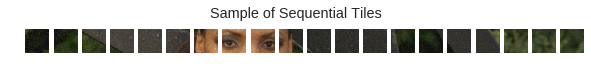

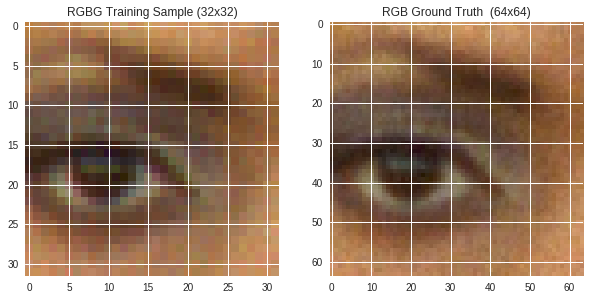

Image:  drive/My Drive/Kodak_Images/IMG0024.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0019.tif
	Full frame shape:  (3072, 2048, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0022.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0023.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0021.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0009.tif
	Full frame shape:  (3072, 2048, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0008.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0020.tif
	Full frame shape:  (2048, 3072, 3)
	Tiles shape:  (1536, 64, 64, 3)
Image:  drive/My Drive/Kodak_Images/IMG0011.tif
	Full frame shap

In [7]:
# Arrays to hold dataset
x_full = []
y_full = []

# For each full frame Kodak image
for idx,img in enumerate(img_list):
  
  # Load in the full frame RGB image
  img_path = DATA_ROOT+"/"+img
  full_frame = plt.imread(img_path)
  # Tile the full frame into all possible 64x64 patches
  tiles = np.array([np.copy(full_frame[x:x+64,y:y+64]) for x in range(0,full_frame.shape[0],64) for y in range(0,full_frame.shape[1],64)])
  
  print("Image: ",img_path)
  print("\tFull frame shape: ",full_frame.shape)
  print("\tTiles shape: ",tiles.shape)
  
  # For each tile
  for j in range(len(tiles)):
    
    # Create Bayer image for this patch
    tmp_bayer = create_approximate_bayer_from_rgb(np.copy(tiles[j]))
    
    # Create downsampled RGBG image for the Bayer
    tmp_rgbg = bayer_to_downsampled_rgbg(np.copy(tmp_bayer))
    
    # Save RGBG & tile as input,output pair
    x_full.append(np.copy(tmp_rgbg)) # Save as CHW
    y_full.append(np.copy(tiles[j]).transpose(2,0,1)) # Save as CHW
  
  assert(len(x_full) == len(y_full))
  
  # Plot on the first iteration
  if idx == 0:
    plt.figure(figsize=(10,1))
    for i in range(20):
      plt.subplot(1,20,i+1)
      plt.imshow(tiles[12*32+10+i])
      plt.grid(False)
      plt.axis("off")
      plt.suptitle("Sample of Sequential Tiles")
    plt.show()
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(np.copy(x_full[401][0:3,:,:]).transpose(1,2,0))
    plt.title("RGBG Training Sample (32x32)")
    plt.subplot(1,2,2)
    plt.imshow(np.copy(y_full[401]).transpose(1,2,0))
    plt.title("RGB Ground Truth  (64x64)")
    plt.show()
    
print("Added all image tiles...")
print("x_full: ", np.array(x_full).shape)
print("y_full: ", np.array(y_full).shape)


## Create training and validation splits of full dataset

In [8]:
# Create a validation split of 10% of full dataset
full_size = len(x_full)
validation_size = int(full_size*0.1)
val_inds = np.random.choice(range(full_size), size=validation_size, replace=False)
train_inds = np.array([int(x) for x in range(full_size) if x not in val_inds])
assert(set(val_inds).isdisjoint(train_inds))

# Create the splits
x_train = np.array([x_full[x] for x in train_inds])
y_train = np.array([y_full[x] for x in train_inds])
x_val = np.array([x_full[x] for x in val_inds])
y_val = np.array([y_full[x] for x in val_inds])

print("# train: ", train_inds.shape)
print("# val: ", val_inds.shape)
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)
print("x_val.shape: ",x_val.shape)
print("y_val.shape: ",y_val.shape)

# normalize data
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
print(np.max(x_train[0]))
x_train /= 255.
x_val /= 255.
y_train /= 255.
y_val /= 255.
print(np.max(x_train[0]))

# train:  (33178,)
# val:  (3686,)
x_train.shape:  (33178, 4, 32, 32)
y_train.shape:  (33178, 3, 64, 64)
x_val.shape:  (3686, 4, 32, 32)
y_val.shape:  (3686, 3, 64, 64)
113.0
0.44313726


## DNN 

Now that we have our dataset formed, we can create and train the DNN for this project. During development of this notebook we tried several model architectures and the v5 worked the best. Large models like the one described in [1] seem to be quite overparameterized and we can achieve good results with a much smaller model. Also, training time is much faster.

### Define model architecture

In [0]:
# Basic Model
# Does NOT work well. Seems to be overparameterized. Loss saturates quickly to
#   about 0.04 and does not improve from there (learning seems to get stuck). 
#   Output images are mostly grey.
def basic_model():
    model = Sequential()
    # Nx4x32x32
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(4,32,32)))
    # Nx16x32x32
    model.add(Conv2D(16,(3, 3), padding='same', activation='relu'))
    # Nx16x32x32
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    # Nx16x32x32
    model.add(Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same'))
    # Nx8x64x64
    model.add(Conv2D(3, (3, 3), padding='same', activation='relu'))
    # Nx3x32x32
    model.add(Activation('sigmoid'))
    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model
  
# Does NOT work well. Seems to be overparameterized. Loss saturates quickly to
#   about 0.04 and does not improve from there (learning seems to get stuck). 
#   Output images are mostly grey.
def basic_model_v2():
    model = Sequential()
    # Nx4x32x32
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(4,32,32)))
    # Nx16x32x32
    model.add(Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same'))
    # Nx8x64x64
    model.add(Conv2D(3, (3, 3), padding='same', activation='relu'))
    # Nx3x32x32
    model.add(Activation('sigmoid'))
    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model

# Seems to work VERY well. Learns quickly and loss steadily converges to about
#    4e-4. Outputs are good. This model does not seem to be way overparameterized
#    like the others. I think the main pitfall is that MSE loss is not a great
#    metric for learning sharp image outputs.
def basic_model_v3():
    model = Sequential()
    # Nx4x32x32
    model.add(UpSampling2D((2, 2), input_shape=(4,32,32)))
    # Nx4x64x64
    model.add(Conv2D(3, (3, 3), padding='same'))
    # Nx3x64x64
    model.add(Activation('sigmoid'))
    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model
  
# Seems to work well. Similar to v3 just more expensive because more parameters
def basic_model_v4():
    model = Sequential()
    # Nx4x32x32
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=(4,32,32)))
    # Nx8x32x32
    model.add(UpSampling2D((2, 2)))
    # Nx8x64x64
    model.add(Conv2D(3, (3, 3), padding='same'))
    # Nx3x64x64
    model.add(Activation('sigmoid'))
    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model
  
# Seems to work well. Similar to v3 & v4 just more expensive because more parameters
def basic_model_v5():
    model = Sequential()
    # Nx4x32x32
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=(4,32,32)))
    # Nx8x32x32
    model.add(Conv2D(16, (3, 3), padding='same'))
    # Nx16x32x32
    model.add(UpSampling2D((2, 2)))
    # Nx16x64x64
    model.add(Conv2D(3, (3, 3), padding='same'))
    # Nx3x64x64
    model.add(Activation('sigmoid'))
    # Define training functions
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model

### Initialize and train model

Note: we train and save the v5 architecture. The model weights are saved in google drive.

In [10]:
cnn_n = basic_model_v5()
cnn_n.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 32, 32)         296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 32)        1168      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 64, 64)         435       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 64, 64)         0         
Total params: 1,899
Trainable params: 1,899
Non-trainable params: 0
_________________________________________________________________


In [0]:
chkpt = 'drive/My Drive/Model_v5_Weights.hdf5'
cp_cb = keras.callbacks.ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [12]:
cnn_n.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val,y_val), callbacks=[cp_cb], shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 33178 samples, validate on 3686 samples
Epoch 1/100
33178/33178 [==============================] - 13s 390us/step - loss: 0.0215 - val_loss: 0.0022

Epoch 00001: val_loss improved from inf to 0.00223, saving model to drive/My Drive/Model_v5_Weights.hdf5
Epoch 2/100
33178/33178 [==============================] - 10s 297us/step - loss: 0.0017 - val_loss: 0.0014

Epoch 00002: val_loss improved from 0.00223 to 0.00139, saving model to drive/My Drive/Model_v5_Weights.hdf5
Epoch 3/100
33178/33178 [==============================] - 10s 301us/step - loss: 0.0013 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00139 to 0.00120, saving model to drive/My Drive/Model_v5_Weights.hdf5
Epoch 4/100
33178/33178 [==============================] - 10s 299us/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00004: val_loss improved from 0.00120 to 0.00106, saving model to drive/My Drive/Model_v5_Weights.hdf5
Epoch 5/100
33178/33178 [==========

From looking at the training log we can see that the validation loss decreased to about 3.2e-4 is the MSE between generated examples and ground truth images in the validation set. Next, we plot the loss curves for this run.

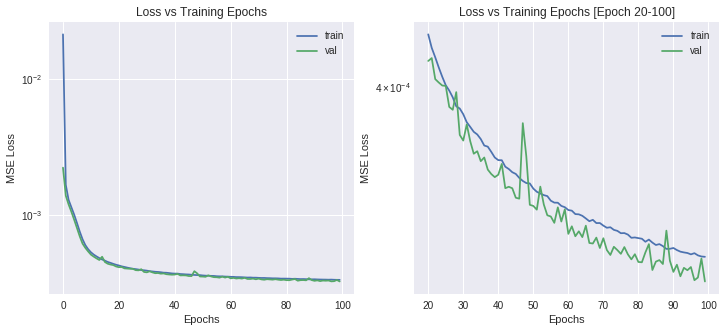

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cnn_n.history.history['loss'],label='train')
plt.plot(cnn_n.history.history['val_loss'],label='val')
plt.legend()
plt.title("Loss vs Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.subplot(1,2,2)
plt.plot(range(20,100),cnn_n.history.history['loss'][20:],label='train')
plt.plot(range(20,100),cnn_n.history.history['val_loss'][20:],label='val')
plt.legend()
plt.title("Loss vs Training Epochs [Epoch 20-100]")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.show()

From above, we see that both losses quickly decreased during the first 20 epochs then begin to saturate around the 80th epoch. 

We can also visualize some input, prediction, ground truth triplets from the validation set to see what the generated samples look like. 

Samples of (Input, Output, Ground Truth) triplets


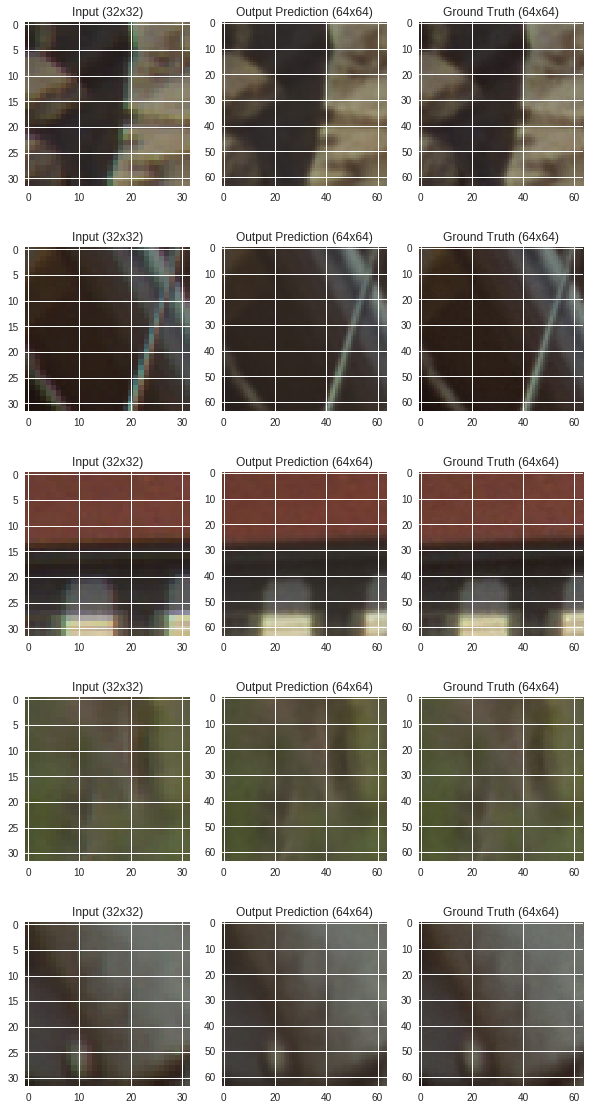

In [0]:
print("Samples of (Input, Output, Ground Truth) triplets")
plt.figure(figsize=(10,20))
for jj in range(5):
  N = np.random.randint(low=0,high=3000)
  eg1 = cnn_n.predict(np.expand_dims(x_val[N],axis=0))
  plt.subplot(5,3,3*jj+1)
  plt.imshow(np.copy(x_val[N][0:3,:,:]).transpose(1,2,0))
  plt.title("Input (32x32)")
  plt.subplot(5,3,3*jj+2)
  plt.imshow(np.copy(eg1[0]).transpose(1,2,0))
  plt.title("Output Prediction (64x64)")
  plt.subplot(5,3,3*jj+3)
  plt.imshow(np.copy(y_val[N]).transpose(1,2,0))
  plt.title("Ground Truth (64x64)")
plt.show()

From the above images, we see our model has learned a reasonably good function to upscale the images. The first 3 samples show that the model can create clean lines in the image that do not look as pixelated as the originals and the last two images show the model is capable of matching the texture of the ground truth images. Now, we will move to the other notebook that interfaces with the IP cameras and use the saved model to transform the raw bayer images to full scale rgb images.

**See other notebook**

In [0]:
# May be useful later

#import random
#def randomCrop(img, width, height):
#    assert img.shape[0] >= height
#   assert img.shape[1] >= width
#   x = random.randint(0, img.shape[1] - width)
#    y = random.randint(0, img.shape[0] - height)
#    img = img[y:y+height, x:x+width]
#    return img
